# 1. Import required modules

In [0]:

from pyspark.sql.functions import col, desc, count, avg



# 2. Read F1 CSV files from DBFS (adjust path if needed)

In [0]:

races = spark.read.csv('/Volumes/filestore/formulaone/formuladump/races.csv', header=True, inferSchema=True)
drivers = spark.read.csv('/Volumes/filestore/formulaone/formuladump/drivers.csv', header=True, inferSchema=True)
results = spark.read.csv('/Volumes/filestore/formulaone/formuladump/results.csv', header=True, inferSchema=True)
constructors = spark.read.csv('/Volumes/filestore/formulaone/formuladump/constructors.csv', header=True, inferSchema=True)
lap_times = spark.read.csv('/Volumes/filestore/formulaone/formuladump/lap_times.csv', header=True, inferSchema=True)

# Show the first few entries of each DataFrame

In [0]:

races.show(3)
drivers.show(3)
results.show(3)
constructors.show(3)
lap_times.show(3)

+------+----+-----+---------+--------------------+----------+--------+--------------------+--------+--------+--------+--------+--------+--------+----------+----------+-----------+-----------+
|raceId|year|round|circuitId|                name|      date|    time|                 url|fp1_date|fp1_time|fp2_date|fp2_time|fp3_date|fp3_time|quali_date|quali_time|sprint_date|sprint_time|
+------+----+-----+---------+--------------------+----------+--------+--------------------+--------+--------+--------+--------+--------+--------+----------+----------+-----------+-----------+
|     1|2009|    1|        1|Australian Grand ...|2009-03-29|06:00:00|http://en.wikiped...|      \N|      \N|      \N|      \N|      \N|      \N|        \N|        \N|         \N|         \N|
|     2|2009|    2|        2|Malaysian Grand Prix|2009-04-05|09:00:00|http://en.wikiped...|      \N|      \N|      \N|      \N|      \N|      \N|        \N|        \N|         \N|         \N|
|     3|2009|    3|       17|  Chinese G

# 3. Check data types and nulls

In [0]:
print("Drivers Schema:")
drivers.printSchema()
drivers.describe().show()


Drivers Schema:
root
 |-- driverId: integer (nullable = true)
 |-- driverRef: string (nullable = true)
 |-- number: string (nullable = true)
 |-- code: string (nullable = true)
 |-- forename: string (nullable = true)
 |-- surname: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- nationality: string (nullable = true)
 |-- url: string (nullable = true)

+-------+------------------+---------+------------------+----+--------+---------+-----------+--------------------+
|summary|          driverId|driverRef|            number|code|forename|  surname|nationality|                 url|
+-------+------------------+---------+------------------+----+--------+---------+-----------+--------------------+
|  count|               861|      861|               861| 861|     861|      861|        861|                 861|
|   mean|  431.061556329849|     NULL| 33.96610169491525|NULL|    NULL|     NULL|       NULL|                NULL|
| stddev|248.79379651260683|     NULL|28.638632035871264|

# Preview races from a specific year, e.g. 2020

In [0]:

races.filter(col("year") == 2020).select("raceId", "name", "date").show()

+------+--------------------+----------+
|raceId|                name|      date|
+------+--------------------+----------+
|  1031| Austrian Grand Prix|2020-07-05|
|  1032|  Styrian Grand Prix|2020-07-12|
|  1033|Hungarian Grand Prix|2020-07-19|
|  1034|  British Grand Prix|2020-08-02|
|  1035|70th Anniversary ...|2020-08-09|
|  1036|  Spanish Grand Prix|2020-08-16|
|  1037|  Belgian Grand Prix|2020-08-30|
|  1038|  Italian Grand Prix|2020-09-06|
|  1039|   Tuscan Grand Prix|2020-09-13|
|  1040|  Russian Grand Prix|2020-09-27|
|  1041|    Eifel Grand Prix|2020-10-11|
|  1042|Portuguese Grand ...|2020-10-25|
|  1043|Emilia Romagna Gr...|2020-11-01|
|  1044|  Turkish Grand Prix|2020-11-15|
|  1045|  Bahrain Grand Prix|2020-11-29|
|  1046|   Sakhir Grand Prix|2020-12-06|
|  1047|Abu Dhabi Grand Prix|2020-12-13|
+------+--------------------+----------+



#4. Analysis 1: Most Race Wins by Driver (All-Time)

# Find race winners (positionOrder == 1)

In [0]:
winners = results.filter(col("positionOrder") == 1).join(drivers, "driverId")

# Aggregate wins by driver

In [0]:

driver_wins = winners.groupBy("surname", "forename").agg(count("*").alias("total_wins"))



# Show top 10 drivers

In [0]:
driver_wins.orderBy(desc("total_wins")).show(10)

+----------+---------+----------+
|   surname| forename|total_wins|
+----------+---------+----------+
|  Hamilton|    Lewis|       105|
|Schumacher|  Michael|        91|
|Verstappen|      Max|        63|
|    Vettel|Sebastian|        53|
|     Prost|    Alain|        51|
|     Senna|   Ayrton|        41|
|    Alonso| Fernando|        32|
|   Mansell|    Nigel|        31|
|   Stewart|   Jackie|        27|
|     Lauda|     Niki|        25|
+----------+---------+----------+
only showing top 10 rows


#5. Analysis 2: Top Drivers by Year

# Join races for year info

In [0]:
winners_with_year = winners.join(races, "raceId")

# Wins per driver per year

In [0]:
wins_per_year = winners_with_year.groupBy("year", "surname", "forename")\
    .agg(count("*").alias("wins"))

# Show example for 2019

In [0]:
wins_per_year.filter(col("year") == 2019).orderBy(desc("wins")).show()

+----+----------+---------+----+
|year|   surname| forename|wins|
+----+----------+---------+----+
|2019|  Hamilton|    Lewis|  11|
|2019|    Bottas| Valtteri|   4|
|2019|Verstappen|      Max|   3|
|2019|   Leclerc|  Charles|   2|
|2019|    Vettel|Sebastian|   1|
+----+----------+---------+----+



#6. Analysis 3: Fastest Lap per Race

## Find fastest lap time per race

In [0]:
fastest_laps = lap_times.groupBy("raceId", "driverId")\
    .agg(avg("milliseconds").alias("avg_lap_time"))

# Find the fastest driver per race

In [0]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

window = Window.partitionBy("raceId").orderBy("avg_lap_time")
fastest_per_race = fastest_laps.withColumn("rank", F.rank().over(window)).filter(col("rank") == 1)

# Join with drivers to get names

In [0]:
fastest_per_race = fastest_per_race.join(drivers, "driverId").select("raceId", "surname", "forename", "avg_lap_time")
fastest_per_race.show(10)

+------+--------+---------+------------------+
|raceId| surname| forename|      avg_lap_time|
+------+--------+---------+------------------+
|     1|Nakajima|   Kazuki| 91822.23529411765|
|     2|  Button|   Jenson|107439.41935483871|
|     3|  Vettel|Sebastian|126133.66071428571|
|     4|  Button|   Jenson| 96634.77192982456|
|     5|  Button|   Jenson| 88472.75757575757|
|     6|  Button|   Jenson| 77490.79487179487|
|     7|  Button|   Jenson| 89393.93103448275|
|     8|  Vettel|Sebastian| 82822.13333333333|
|     9|  Webber|     Mark| 96721.83333333333|
|    10|Hamilton|    Lewis| 84341.08571428571|
+------+--------+---------+------------------+
only showing top 10 rows


#7. Visualization: Convert to pandas for plotting

# A. Total Wins by Driver

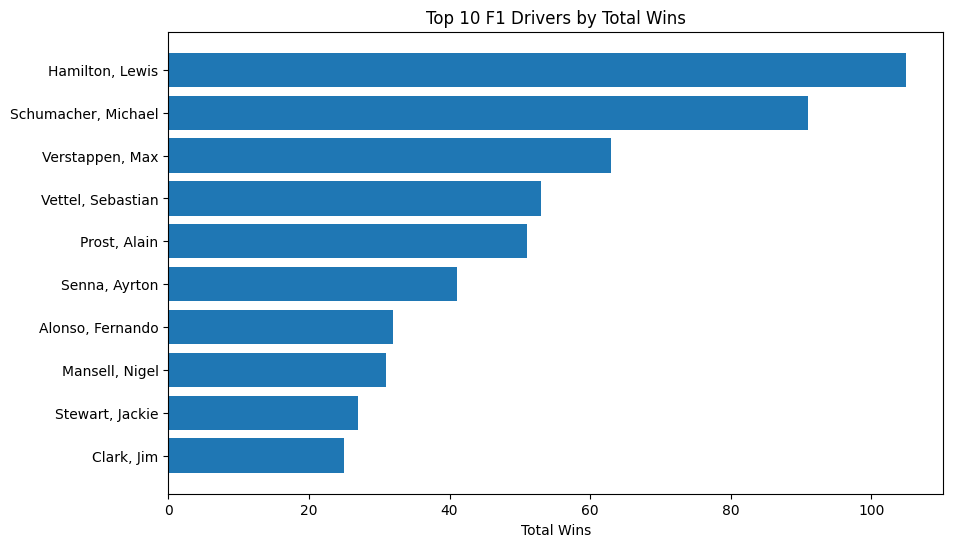

In [0]:

pdf = driver_wins.orderBy(desc("total_wins")).limit(10).toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(pdf['surname'] + ', ' + pdf['forename'], pdf['total_wins'], color='#1f77b4')
plt.xlabel("Total Wins")
plt.title("Top 10 F1 Drivers by Total Wins")
plt.gca().invert_yaxis()
plt.show()


# B. Constructor (Team) Analysis: Total Wins by Team

# Join winners with constructors to get team names

In [0]:
winners_with_team = winners.join(results.select("raceId", "driverId", "constructorId"), ["raceId", "driverId"])\
                           .join(constructors, "constructorId")



# Total wins per constructor (all-time)


In [0]:

team_wins = winners_with_team.groupBy("name").agg(count("*").alias("total_wins"))

# Show top teams


In [0]:
team_wins.orderBy(desc("total_wins")).show(10)

+----------+----------+
|      name|total_wins|
+----------+----------+
|   Ferrari|       250|
|   McLaren|       185|
|  Mercedes|       129|
|  Red Bull|       122|
|  Williams|       114|
|Team Lotus|        45|
|   Renault|        35|
|  Benetton|        27|
|   Brabham|        23|
|   Tyrrell|        23|
+----------+----------+
only showing top 10 rows


# Bar Chart: Top 10 Constructors by Total Wins

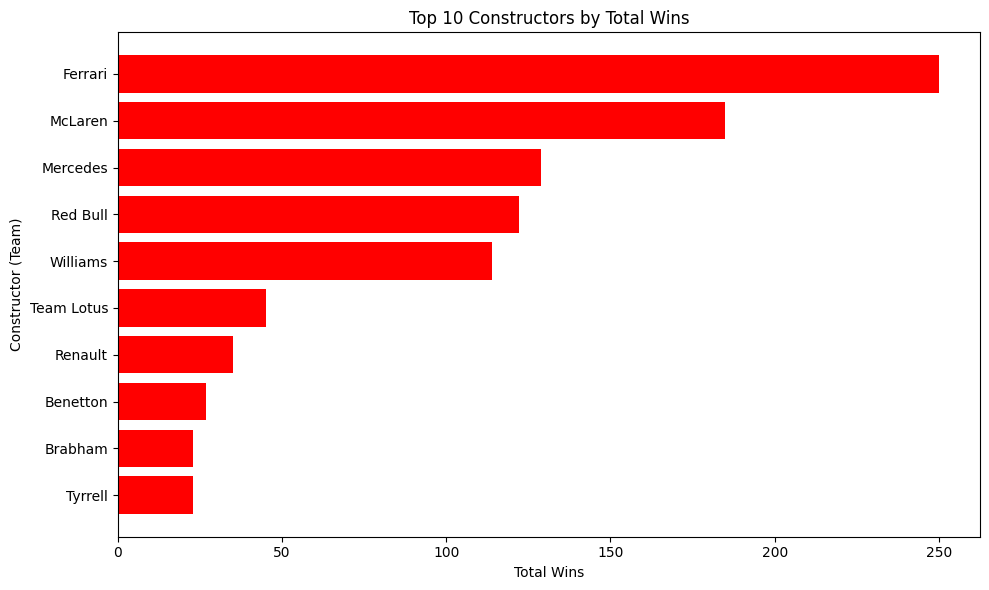

In [0]:
team_win_pdf = team_wins.orderBy(desc("total_wins")).limit(10).toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(team_win_pdf['name'], team_win_pdf['total_wins'], color='red')
plt.xlabel("Total Wins")
plt.ylabel("Constructor (Team)")
plt.title("Top 10 Constructors by Total Wins")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#2. Win Percentage Per Team by Season
# Calculate total races per season

In [0]:
races_per_season = races.groupBy("year").agg(count("*").alias("total_races"))

# Total wins per team per year

In [0]:

team_wins_year = winners_with_team.join(races, "raceId")\
    .groupBy("year", "name")\
    .agg(count("*").alias("wins"))



# Join with total races per season

In [0]:

team_win_pct = team_wins_year.join(races_per_season, "year")\
    .withColumn("win_percent", (col("wins") / col("total_races")) * 100)


In [0]:
# When you join constructors and races, rename their name columns

from pyspark.sql.functions import col

# Rename constructors name as 'team_name'
constructors_renamed = constructors.withColumnRenamed("name", "team_name")
# If you join circuits or races, also rename e.g., 'race_name' or 'circuit_name'

winners_with_team = winners.join(
    results.select("raceId", "driverId", "constructorId"), ["raceId", "driverId"]
).join(
    constructors_renamed, "constructorId"
)
# Now 'team_name' is unique!

team_wins_year = winners_with_team.join(races, "raceId") \
    .groupBy("year", "team_name") \
    .agg(count("*").alias("wins"))


In [0]:
team_win_pct = team_wins_year.join(races_per_season, "year") \
    .withColumn("win_percent", (col("wins") / col("total_races")) * 100)
team_win_pct.orderBy("year", desc("win_percent")).show(20)


+----+------------+----+-----------+------------------+
|year|   team_name|wins|total_races|       win_percent|
+----+------------+----+-----------+------------------+
|1950|  Alfa Romeo|   6|          7| 85.71428571428571|
|1950|Kurtis Kraft|   1|          7|14.285714285714285|
|1951|  Alfa Romeo|   7|          8|              87.5|
|1951|     Ferrari|   3|          8|              37.5|
|1951|Kurtis Kraft|   1|          8|              12.5|
|1952|     Ferrari|   7|          8|              87.5|
|1952|       Kuzma|   1|          8|              12.5|
|1953|     Ferrari|   7|          9| 77.77777777777779|
|1953|Kurtis Kraft|   1|          9| 11.11111111111111|
|1953|    Maserati|   1|          9| 11.11111111111111|
|1954|    Mercedes|   4|          9| 44.44444444444444|
|1954|    Maserati|   2|          9| 22.22222222222222|
|1954|     Ferrari|   2|          9| 22.22222222222222|
|1954|Kurtis Kraft|   1|          9| 11.11111111111111|
|1955|    Mercedes|   5|          7| 71.42857142

# Reuse or run the "top3_teams" code to select top three teams

In [0]:
team_win_pct_pdf = team_win_pct.filter(
    col("team_name").isin(top3_teams)
).toPandas()

In [0]:
team_win_pct_pdf = team_win_pct.filter(
    col("team_name").isin(top3_teams)
).toPandas()

In [0]:
top3_teams = [
    row['name'] for row in team_wins.orderBy(
        desc("total_wins")
    ).limit(3).collect()
]
team_win_pct_pdf = team_win_pct.filter(
    col("team_name").isin(top3_teams)
).toPandas()

How To Fix the Visualization
Sort by Year for Each Team—before plotting!

Optionally resample or fill missing years with zeros (to keep team lines continuous).

Also, drop duplicates if any, and clean your DataFrame.

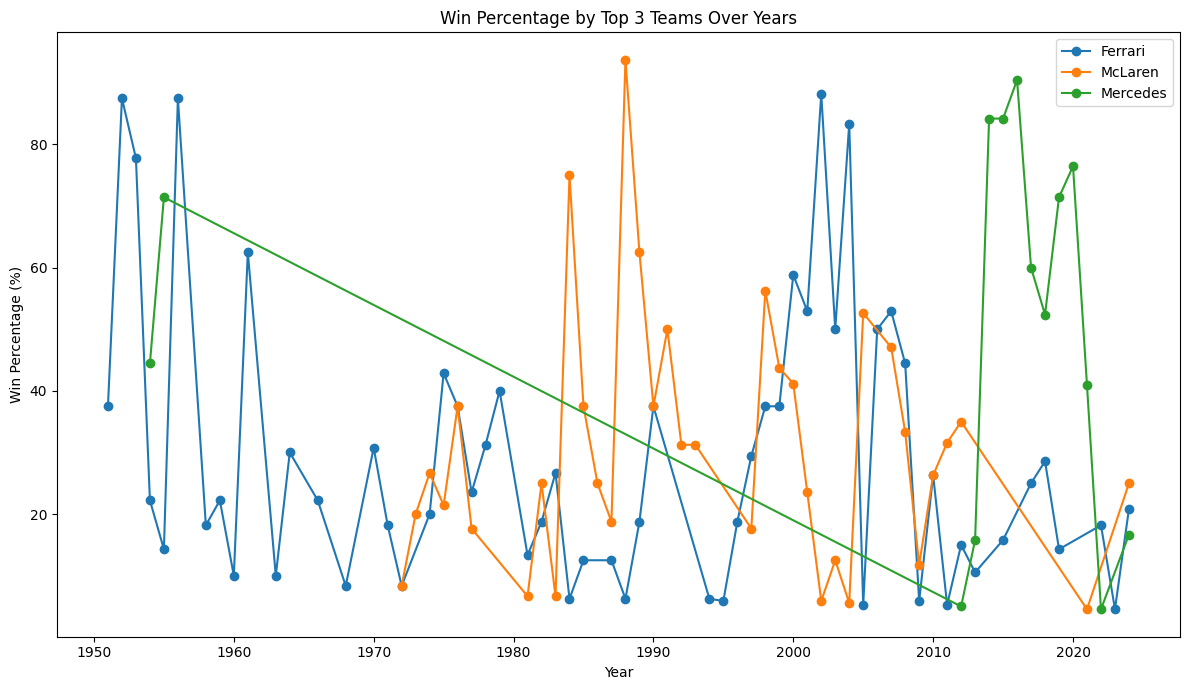

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))
for team in top3_teams:
    team_data = team_win_pct_pdf[team_win_pct_pdf['team_name'] == team].sort_values('year')
    plt.plot(team_data['year'], team_data['win_percent'], marker='o', label=team)
plt.title("Win Percentage by Top 3 Teams Over Years")
plt.xlabel("Year")
plt.ylabel("Win Percentage (%)")
plt.legend()
plt.tight_layout()
plt.show()


If you want every year shown (even if a team had zero wins that year):

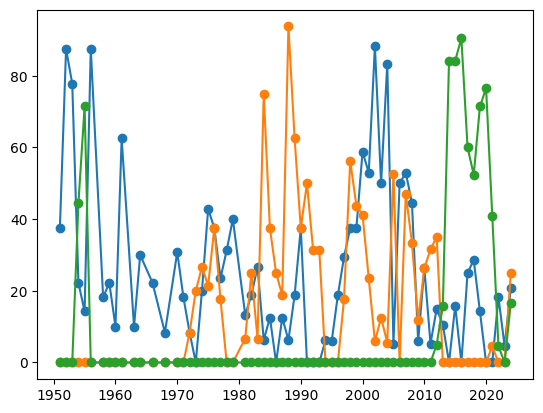

In [0]:
all_years = sorted(team_win_pct_pdf['year'].unique())
for team in top3_teams:
    team_data = team_win_pct_pdf[team_win_pct_pdf['team_name'] == team].set_index('year').sort_index()
    team_data = team_data.reindex(all_years, fill_value=0)
    plt.plot(team_data.index, team_data['win_percent'], marker='o', label=team)
